In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, jaccard_score, matthews_corrcoef, roc_curve, auc

In [10]:
def load_images_from_dir(dir_path):
    images = []
    labels = []
    for class_dir in os.listdir(dir_path):
        class_path = os.path.join(dir_path, class_dir)
        label = 1 if class_dir.lower() == 'fire' else 0
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = load_img(img_path, target_size=(150, 150))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

In [11]:
original_dir = '/kaggle/input/effective-forest-fire/Effective Forest Fire Detection Data-set for Heterogeneous Wireless Multimedia Sensor Networks/forest_images_dataset'
generated_dir = '/kaggle/input/forest-fire-classification-dataset/forest_fire_diffusion_generated/forest_fire_diffusion_generated'

original_images, original_labels = load_images_from_dir(original_dir)
generated_images, generated_labels = load_images_from_dir(generated_dir)

all_images = np.concatenate([original_images, generated_images], axis=0)
all_labels = np.concatenate([original_labels, generated_labels], axis=0)

all_images = all_images.astype('float32') / 255.0



In [12]:
print(f"Total images: {len(all_images)}, Total labels: {len(all_labels)}")
unique, counts = np.unique(all_labels, return_counts=True)
print(f"All labels distribution: {dict(zip(unique, counts))}")

Total images: 5709, Total labels: 5709
All labels distribution: {0: 3585, 1: 2124}


In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_model_cnn(learning_rate=0.0001):
    input_layer = Input(shape=(150, 150, 3))
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, roc_curve, auc, precision_score,
                             recall_score, f1_score, jaccard_score, matthews_corrcoef)
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_train_loss = []
fold_val_loss = []
fold_train_acc = []
fold_val_acc = []
confusion_matrices = []
roc_aucs = []

precision_list = []
recall_list = []
f1_list = []
jaccard_list = []
mcc_list = []

all_labels = np.array(all_labels)

all_true_labels = []
all_predictions = []

fold_num = 1
for train_index, val_index in kf.split(all_images):
    print(f"Fold {fold_num}")
    X_train, X_val = all_images[train_index], all_images[val_index]
    y_train, y_val = all_labels[train_index], all_labels[val_index]
    
    datagen = ImageDataGenerator(rotation_range=5, width_shift_range=0.1,
                                 height_shift_range=0.1, shear_range=0.1,
                                 zoom_range=0.1, horizontal_flip=True)
    datagen.fit(X_train)

    model = create_model_cnn(learning_rate=0.0001)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
    
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        validation_data=(X_val, y_val), 
                        epochs=50, 
                        callbacks=[early_stopping],
                        verbose=1)
    
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}")
    
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

    fold_train_loss.append(history.history['loss'])
    fold_val_loss.append(history.history['val_loss'])
    fold_train_acc.append(history.history['accuracy'])
    fold_val_acc.append(history.history['val_accuracy'])

    y_val_pred = model.predict(X_val, verbose=0)
    y_val_pred_class = np.where(y_val_pred > 0.5, 1, 0).flatten()

    all_true_labels.append(y_val)
    all_predictions.append(y_val_pred)

    cm = confusion_matrix(y_val, y_val_pred_class)
    confusion_matrices.append(cm)
    
    precision = precision_score(y_val, y_val_pred_class)
    recall = recall_score(y_val, y_val_pred_class)
    f1 = f1_score(y_val, y_val_pred_class)
    jaccard = jaccard_score(y_val, y_val_pred_class)
    mcc = matthews_corrcoef(y_val, y_val_pred_class)
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    jaccard_list.append(jaccard)
    mcc_list.append(mcc)

    fold_num += 1

average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1 = np.mean(f1_list)
average_jaccard = np.mean(jaccard_list)
average_mcc = np.mean(mcc_list)

average_train_loss = np.mean([loss[-1] for loss in fold_train_loss])
average_val_loss = np.mean([loss[-1] for loss in fold_val_loss])
average_train_acc = np.mean([acc[-1] for acc in fold_train_acc])
average_val_acc = np.mean([acc[-1] for acc in fold_val_acc])

print(f"\nAverage Training Loss: {average_train_loss:.4f}")
print(f"Average Validation Loss: {average_val_loss:.4f}")
print(f"Average Training Accuracy: {average_train_acc:.4f}")
print(f"Average Validation Accuracy: {average_val_acc:.4f}")

print(f"\nAverage Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1 Score: {average_f1:.4f}")
print(f"Average Jaccard Index: {average_jaccard:.4f}")
print(f"Average MCC: {average_mcc:.4f}")


Fold 1
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731000961.785227    5430 service.cc:145] XLA service 0x7f9a24006340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731000961.785274    5430 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/143 ━━━━━━━━━━━━━━━━━━━━ 27:40 12s/step - accuracy: 0.6875 - loss: 0.9617

I0000 00:00:1731000969.173306    5430 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.8382 - loss: 0.5449 - val_accuracy: 0.6349 - val_loss: 3.6847
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9221 - loss: 0.2932 - val_accuracy: 0.6349 - val_loss: 3.2994
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9432 - loss: 0.2066 - val_accuracy: 0.7539 - val_loss: 1.3659
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9527 - loss: 0.1754 - val_accuracy: 0.8853 - val_loss: 0.4529
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9576 - loss: 0.1720 - val_accuracy: 0.9632 - val_loss: 0.2161
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9580 - loss: 0.1715 - val_accuracy: 0.9694 - val_loss: 0.1430
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9637 - loss: 0.1271 - val_accuracy: 0.9799 - val_loss: 0.1258
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9711 - loss: 0.1061 - val

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 177ms/step - accuracy: 0.8135 - loss: 0.6259 - val_accuracy: 0.6287 - val_loss: 1.8619
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9239 - loss: 0.2753 - val_accuracy: 0.6296 - val_loss: 2.4264
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9443 - loss: 0.2160 - val_accuracy: 0.7461 - val_loss: 1.3370
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9521 - loss: 0.1941 - val_accuracy: 0.8993 - val_loss: 0.4095
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9500 - loss: 0.1774 - val_accuracy: 0.9623 - val_loss: 0.1765
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9650 - loss: 0.1482 - val_accuracy: 0.9790 - val_loss: 0.0659
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9655 - loss: 0.1399 - val_accuracy: 0.9764 - val_loss: 0.1235
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9657 - loss: 0.1669 - val

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 176ms/step - accuracy: 0.8242 - loss: 0.5765 - val_accuracy: 0.6427 - val_loss: 3.5361
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9242 - loss: 0.3079 - val_accuracy: 0.7268 - val_loss: 1.4216
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9302 - loss: 0.2714 - val_accuracy: 0.8380 - val_loss: 0.9353
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9537 - loss: 0.2016 - val_accuracy: 0.9448 - val_loss: 0.2040
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9518 - loss: 0.2011 - val_accuracy: 0.9755 - val_loss: 0.0821
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9576 - loss: 0.1514 - val_accuracy: 0.9825 - val_loss: 0.0624
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9678 - loss: 0.1223 - val_accuracy: 0.9729 - val_loss: 0.0886
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9631 - loss: 0.1339 - val

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 177ms/step - accuracy: 0.8313 - loss: 0.5306 - val_accuracy: 0.6454 - val_loss: 4.3572
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9242 - loss: 0.2655 - val_accuracy: 0.6454 - val_loss: 4.6656
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9437 - loss: 0.2194 - val_accuracy: 0.6891 - val_loss: 1.9035
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9534 - loss: 0.1871 - val_accuracy: 0.9317 - val_loss: 0.3342
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9561 - loss: 0.1850 - val_accuracy: 0.9606 - val_loss: 0.1338
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9584 - loss: 0.1612 - val_accuracy: 0.9729 - val_loss: 0.1293
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9611 - loss: 0.1280 - val_accuracy: 0.9772 - val_loss: 0.1008
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9648 - loss: 0.1256 - val

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 200ms/step - accuracy: 0.8155 - loss: 0.5736 - val_accuracy: 0.5881 - val_loss: 3.7887
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9318 - loss: 0.2469 - val_accuracy: 0.5907 - val_loss: 3.1469
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9436 - loss: 0.1966 - val_accuracy: 0.6293 - val_loss: 3.9351
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9379 - loss: 0.2616 - val_accuracy: 0.8580 - val_loss: 0.5591
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9597 - loss: 0.1517 - val_accuracy: 0.9124 - val_loss: 0.2765
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9650 - loss: 0.1360 - val_accuracy: 0.9798 - val_loss: 0.0601
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9599 - loss: 0.1331 - val_accuracy: 0.9518 - val_loss: 0.1521
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9709 - loss: 0.1061 - val

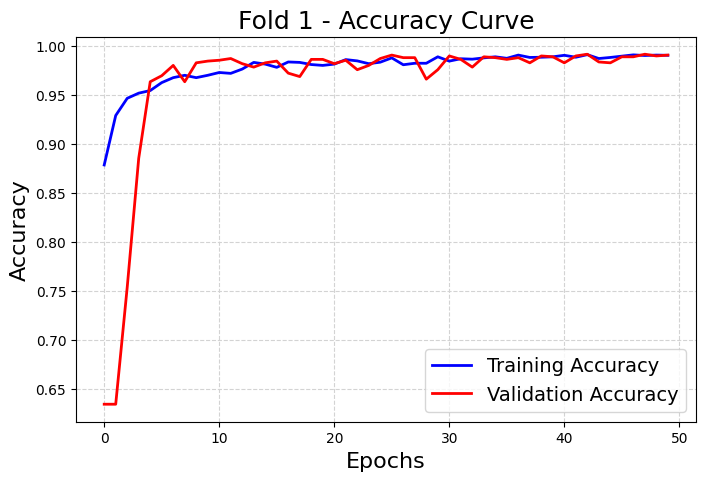

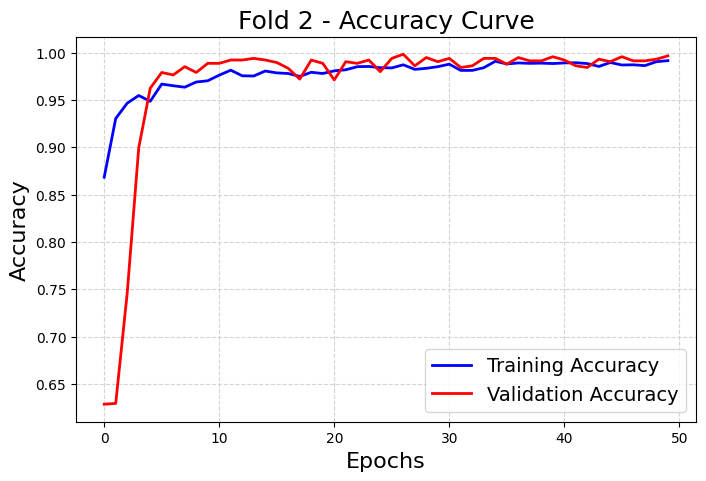

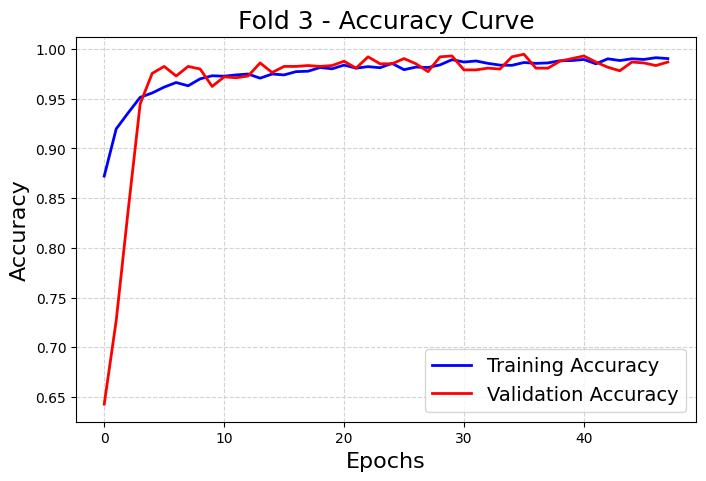

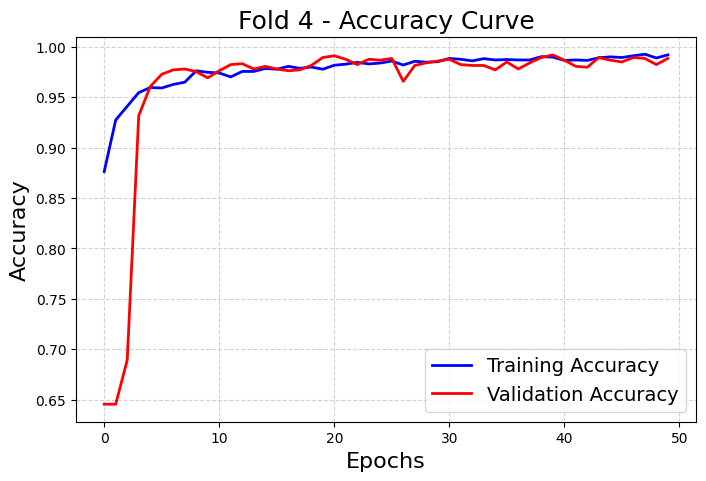

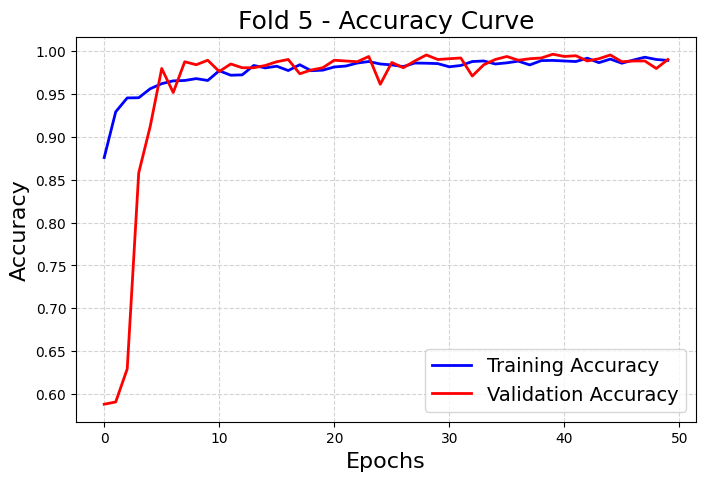

In [15]:
import matplotlib.pyplot as plt

for i in range(k):
    plt.figure(figsize=(8, 5))
    plt.plot(fold_train_acc[i], label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(fold_val_acc[i], label='Validation Accuracy', color='red', linewidth=2)
    plt.title(f'Fold {i + 1} - Accuracy Curve', fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.grid(True, color='lightgrey', linestyle='--')
    plt.legend(fontsize=14, loc='best')
    plt.show()



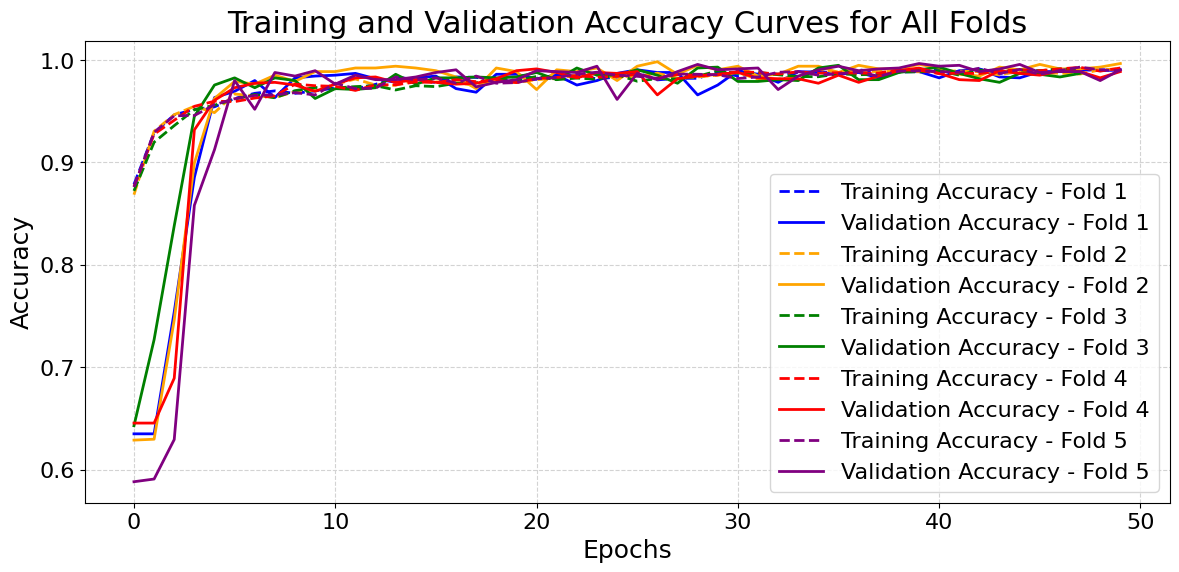

In [17]:
import matplotlib.pyplot as plt

colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(14, 6))

for i in range(k):
    plt.plot(fold_train_acc[i], label=f'Training Accuracy - Fold {i + 1}', color=colors[i], linestyle='--', linewidth=2)
    plt.plot(fold_val_acc[i], label=f'Validation Accuracy - Fold {i + 1}', color=colors[i], linewidth=2)

plt.title('Training and Validation Accuracy Curves for All Folds', fontsize=22)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.grid(True, color='lightgrey', linestyle='--')
plt.legend(loc='lower right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()



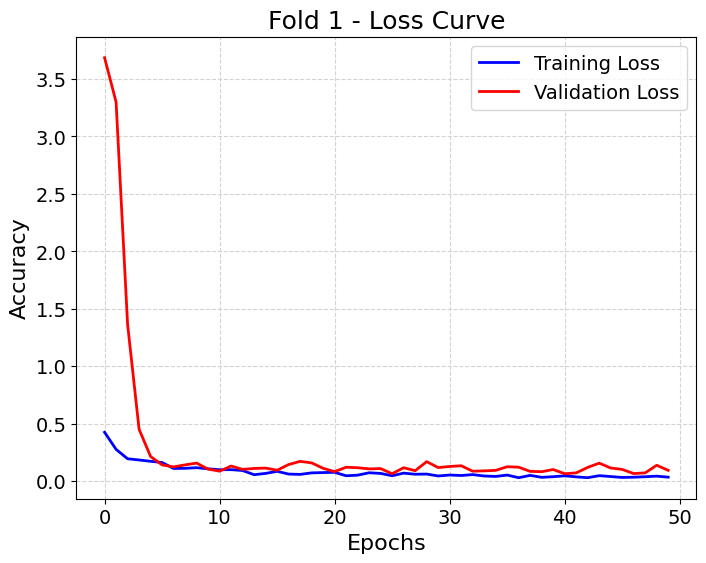

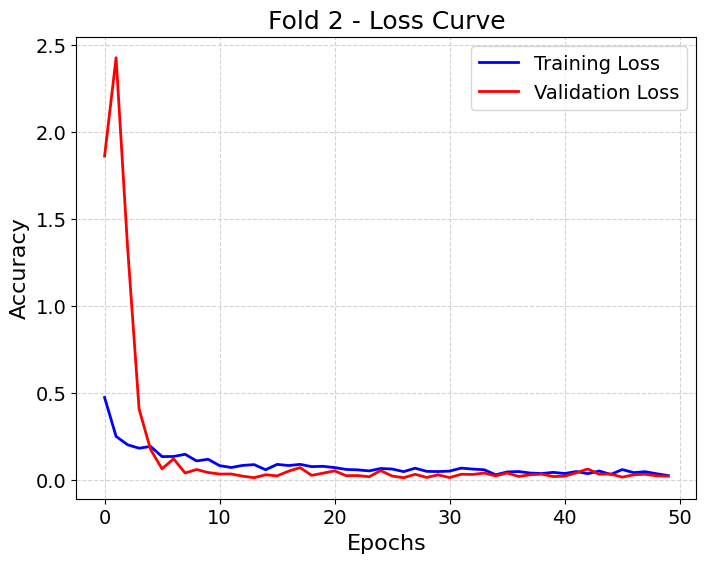

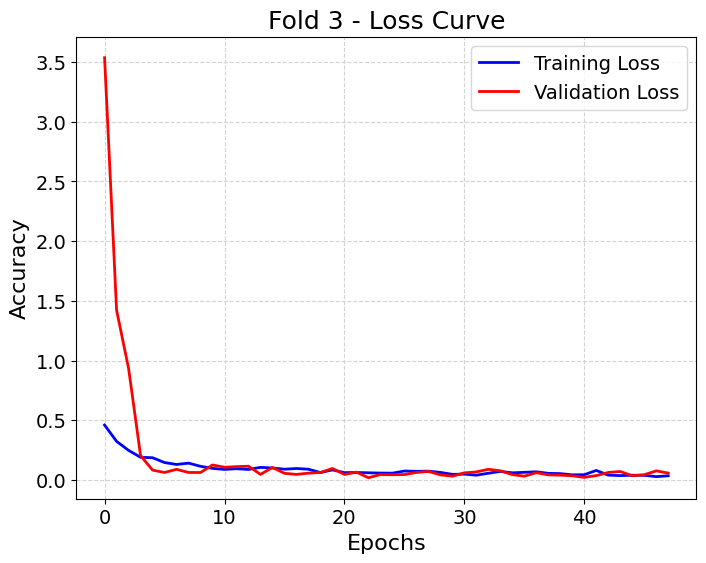

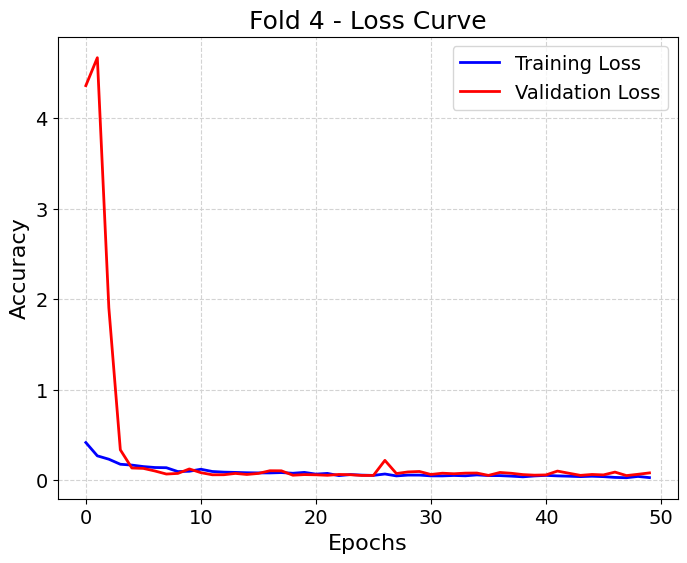

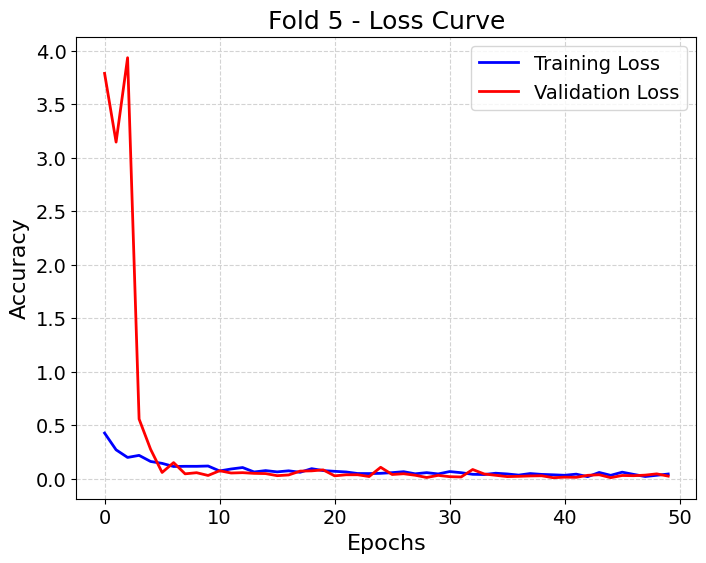

In [19]:
import matplotlib.pyplot as plt

for i in range(k):
    plt.figure(figsize=(8, 6))
    
    plt.plot(fold_train_loss[i], label='Training Loss', color='blue', linewidth=2)
    plt.plot(fold_val_loss[i], label='Validation Loss', color='red', linewidth=2)
    
    plt.title(f'Fold {i + 1} - Loss Curve', fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.grid(True, color='lightgrey', linestyle='--')
    plt.legend(fontsize=14, loc='best')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.show()


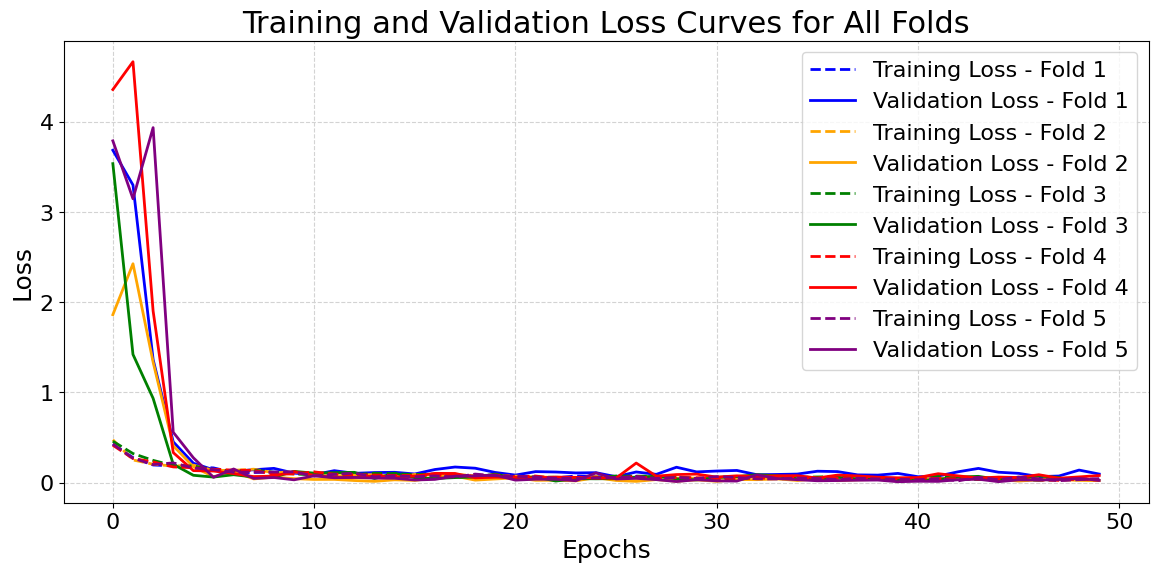

In [21]:
import matplotlib.pyplot as plt

colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(14, 6))

for i in range(k):
    plt.plot(fold_train_loss[i], label=f'Training Loss - Fold {i + 1}', color=colors[i], linestyle='--', linewidth=2)
    plt.plot(fold_val_loss[i], label=f'Validation Loss - Fold {i + 1}', color=colors[i], linewidth=2)

plt.title('Training and Validation Loss Curves for All Folds', fontsize=22)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.grid(True, color='lightgrey', linestyle='--')

plt.legend(loc='upper right', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()



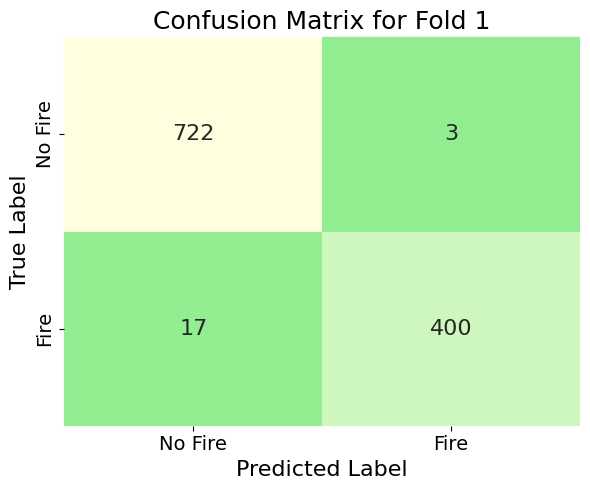

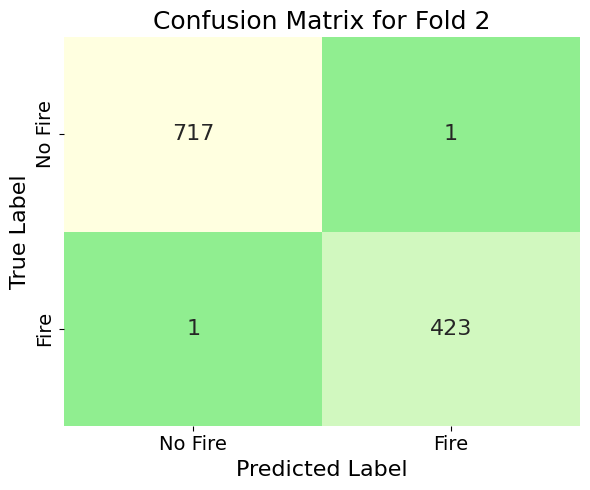

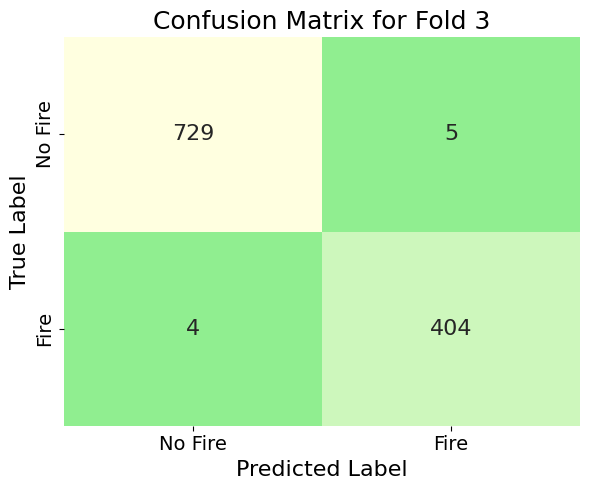

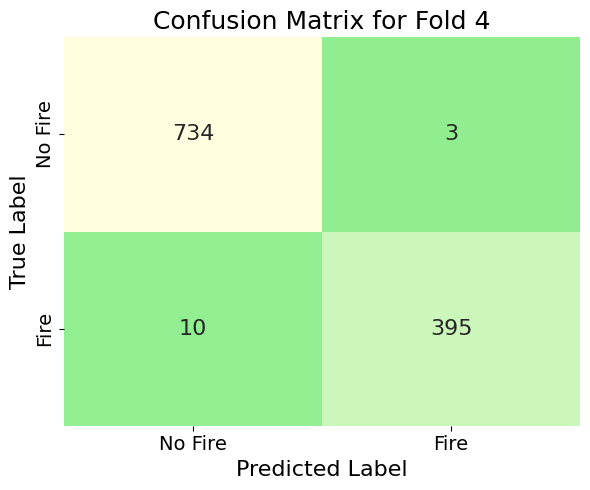

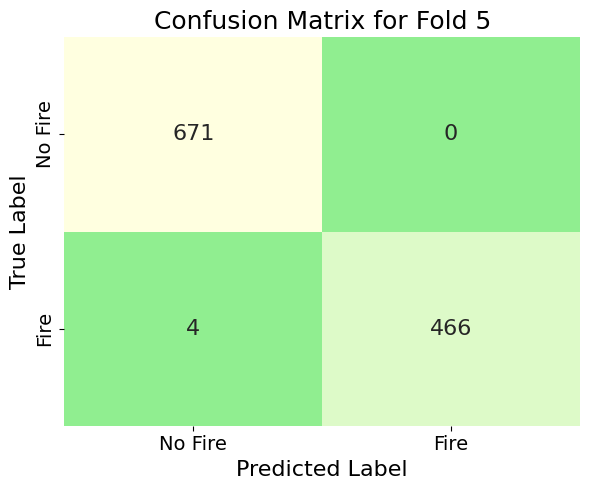

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list('custom_green_yellow', ['lightgreen', 'lightyellow'])

for i, cm in enumerate(confusion_matrices):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, cbar=False, annot_kws={"size": 16},
                xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
    
    plt.title(f'Confusion Matrix for Fold {i + 1}', fontsize=18)
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.tight_layout()
    plt.show()


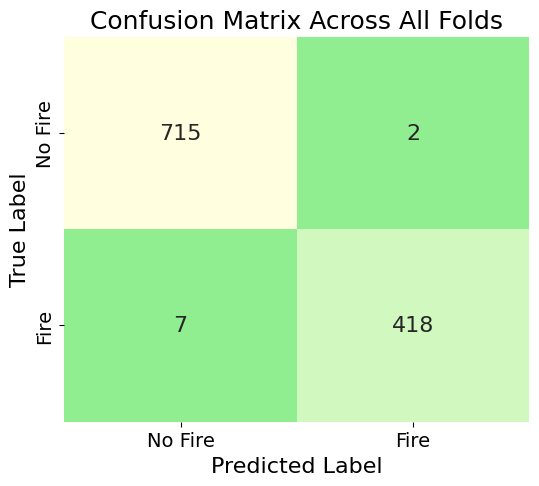

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list('custom_green_yellow', ['lightgreen', 'lightyellow'])

average_cm = np.mean(confusion_matrices, axis=0)
average_cm = np.round(average_cm).astype(int)

plt.figure(figsize=(6, 5))
sns.heatmap(average_cm, annot=True, fmt='d', cmap=custom_cmap, cbar=False, annot_kws={"size": 16},
            xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.title('Confusion Matrix Across All Folds', fontsize=18)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()



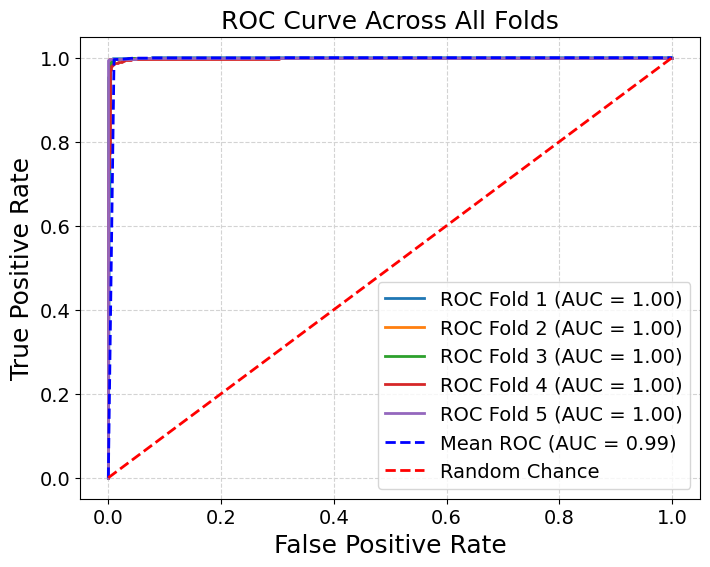

Average AUC across all folds: 0.9992


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

mean_fpr = np.linspace(0, 1, 100)  
tprs = [] 
roc_aucs = []  

plt.figure(figsize=(8, 6))

for i, (y_val, y_val_pred) in enumerate(zip(all_true_labels, all_predictions)):
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0  

    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)

    plt.plot(fpr, tpr, lw=2, label=f'ROC Fold {i+1} (AUC = {roc_auc:.2f})')

mean_tpr = np.mean(tprs, axis=0)  
mean_tpr[-1] = 1.0  
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, linestyle='--', label=f'Mean ROC (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Chance')

plt.title('ROC Curve Across All Folds', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc='lower right', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, color='lightgrey', linestyle='--')

plt.show()

print(f'Average AUC across all folds: {np.mean(roc_aucs):.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


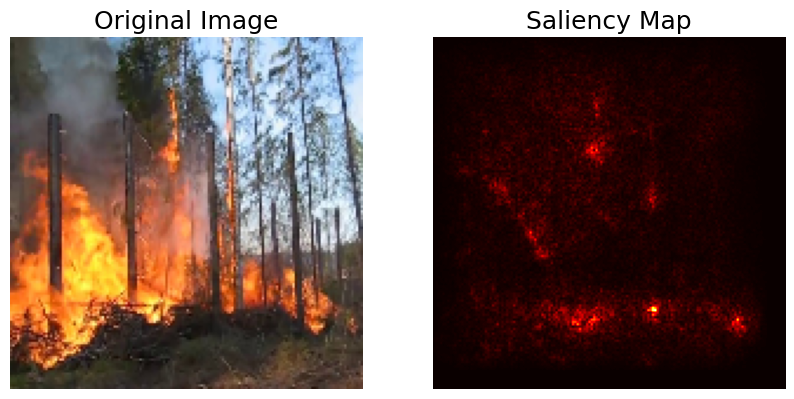

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K

def compute_saliency_map(model, img, class_index=None):
    img = np.expand_dims(img, axis=0)
    img = tf.convert_to_tensor(img, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img) 
        prediction = model(img, training=False)  
        if class_index is None:
            class_index = np.argmax(prediction[0])

        loss = prediction[:, class_index]  

    grads = tape.gradient(loss, img)

    saliency = np.max(np.abs(grads), axis=-1)[0]

    return saliency

def plot_saliency_map(original_img, saliency_map):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image", fontsize=18)
    axes[0].axis('off')
    
    axes[1].imshow(saliency_map, cmap='hot')
    axes[1].set_title("Saliency Map", fontsize=18)
    axes[1].axis('off')

    plt.savefig('B_saliency_map469.pdf', format='pdf', dpi=600, bbox_inches='tight')

    plt.show()


image_index = 469
original_img = X_val[image_index] 
class_index = np.argmax(model.predict(np.expand_dims(original_img, axis=0)))

saliency = compute_saliency_map(model, original_img, class_index)

plot_saliency_map(original_img, saliency)



In [37]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 74, 74, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 36, 36, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 17, 17, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 15, 15, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,592,069 (166.29 MB)

 Trainable params: 14,530,049 (55.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 29,060,100 (110.86 MB)

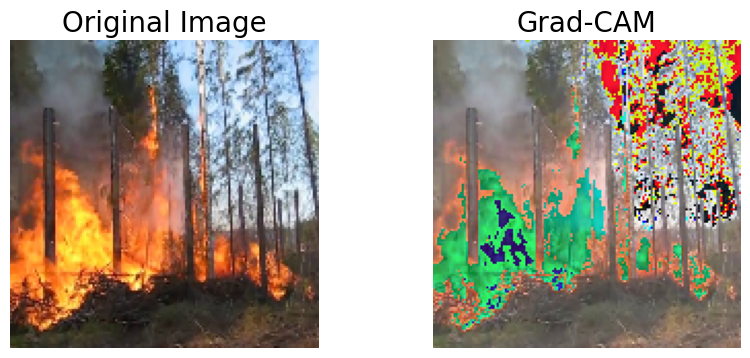

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2

def get_gradcam(model, img_array, last_conv_layer_name, pred_index=None):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    
    if tf.reduce_max(heatmap) > 0:
        heatmap /= tf.reduce_max(heatmap)
    
    return heatmap.numpy()

def display_gradcam(img_array, heatmap, alpha=0.2):
    img = image.array_to_img(img_array)
    img = image.img_to_array(img)
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_OCEAN)
    superimposed_img = heatmap_colored * alpha + img
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image', fontsize=20)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Grad-CAM', fontsize=20)
    plt.imshow(superimposed_img.astype('uint8'))
    plt.axis('off')

    plt.savefig('B_Gradcam469.pdf', format='pdf', dpi=600, bbox_inches='tight')
    plt.show()

specific_image_idx = 469
img_array = X_val[specific_image_idx]
img_array_normalized = img_array / 255.0

heatmap = get_gradcam(model, np.expand_dims(img_array_normalized, axis=0), last_conv_layer_name='conv2d_24')
display_gradcam(img_array, heatmap)
